# Telescope and data specs

This notebook summarises the telescope and data specifications for the SKASDC3.

In [2]:
import numpy as np
from astropy import cosmology, units, constants
import pyuvdata
from itertools import combinations

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rc

In [4]:
rc("font", **{"family": "serif", "serif": ["times new roman"], "size": 15})
rc("text", usetex=True)
rc("axes", linewidth=1.5)

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [6]:
cosmo = cosmology.Planck18

The mock observations simulated for the SKA SDC3 data challenge (see https://sdc3.skao.int/challenges/foregrounds/data) have:
* Frequency coverage 106 - 196 [MHz]
* Channel width 100 [kHz]

We get additional information about the array from Braun et al., 2019 (https://arxiv.org/abs/1912.12699):
* Beam FWHM: 7 arcsecs (mean on frequency range considered)
* FoV: 327 arcmins
* 131 072 log-period dipole antennas, grouped into 512 stations of size 35-40 m each containing 256 antennas, covering 50 to 350 MHz with baselines up to 65 km. For the analysis, we will consider each station as a single antenna - the station's synthesised beam will be the antenna primary beam.

Some of these characteristics are listed below, and compared to HERA for reference.

Telescope | HERA      | SKA |
----------- | ----------- | ----------- |
Bandwidth [MHz] | 100-200    | 106-196       |
Frequency resolution [kHz] | 97   | 100    |
Beam FWHM [deg] | 6.7-7.3 | 0.002
Number of antennas | | 512

## Bandwidth

In [7]:
# 21cm rest-frame frequency
nu0 = 1420e6 * units.Hz

In [8]:
fmin, fmax = 106e6 * units.Hz, 196e6 * units.Hz
df = 100e3 * units.Hz
bandwidth = np.arange(fmin.value, fmax.value + df.value, step=df.value)
print(f'There are {bandwidth.size} frequency channels.')

There are 901 frequency channels.


For both practical and scientific reasons (e.g., light-cone effect), we will consider smaller spectral windows for the analysis. We pick one spectral window with 150 channels, centred on 150MHz.

In [9]:
avg_nu = 150.e6 * units.Hz
avg_z = nu0/avg_nu-1
avg_lamb = constants.c.si / avg_nu.si

nfreqs = 150
iavg = list(bandwidth).index(avg_nu.value)

spw_range = (iavg-150//2, iavg+150//2)
spw_window = bandwidth[spw_range[0]:spw_range[1]]
z_array = nu0.value/spw_window-1.

print(f'{spw_window.size} frequency channels, '\
      f'mean frequency {spw_window.mean()/1e6:.1f}MHz, '\
      f'mean redshift {avg_z:.1f}.')

150 frequency channels, mean frequency 149.9MHz, mean redshift 8.5.


## Beam and resolution

The beam FHWM is given by the antenna size, here the station size. "131 072 log-period dipole antennas, grouped into 512 stations of size 35-40 m"

In [10]:
D_station = (35+40)/2 * units.m
fwhm = (1.22 * avg_lamb / D_station * units.rad).to(units.arcmin)
print(f'The beam FWHM is {fwhm:.1f}.')

The beam FWHM is 223.5 arcmin.


The maximal angular resolution of the telescope is given by the maximum baseline. Let us consider two cases: one where we use the full array (SKA central) and one where we use only the core stations (SKA core), with maximum baselines of, respecitvely, 65km and 2km.

In [11]:
res_core = (1.22 * avg_lamb / (2*units.km) * units.rad)
print(f'The resolution of the core array is {res_core.to(units.arcsec):.1f}.')
res_central = (1.22 * avg_lamb / (65*units.km) * units.rad)
print(f'The resolution of the central array is {res_central.to(units.arcsec):.1f}.')

The resolution of the core array is 251.5 arcsec.
The resolution of the central array is 7.7 arcsec.


Note that the Data challenge website indicates a pixel size of 16x16 arcsecs (which is close to the central array resolution), so this is what we will use in the remaining of this notebook.

In [12]:
ang_res = 16.*units.arcsec

## Simulation properties

Let's convert to cosmological units to generate the validation simulations.


### Line-of-sight resolution

To obtain the resolution needed along the line-of-sight direction, we have
\begin{equation}
\Delta x= \frac{c \sqrt{1+z}}{H_0 \nu_0 \sqrt{\Omega_{\mathrm{m}}}}  \Delta \nu
\end{equation}
for $\Delta \nu$ the frequency resolution in Hz and $\Delta x$ the comoving spatial resolution in Mpc.

In [13]:
los_res = (constants.c.si * np.sqrt(1.+avg_z) / cosmo.H0.si / nu0.si / np.sqrt(cosmo.Om0) * df.si).to(units.Mpc)
print(f'The resolution along the line of sight should be {los_res:.1f}.')

The resolution along the line of sight should be 1.7 Mpc.


### Angular resolution

We use the equation:
\begin{equation}
\tan \left(\frac{\theta}{2} \right) = \frac{L}{2d_c(z)} \leftrightarrow L = 2 d_c(z) \tan \left(\frac{\theta}{2} \right)
\end{equation}
where $\theta$ is the sky angle, $L$ is the corresponding physical size at redshift $z$ and $d_c(z)$ is the comoving distance to $z$.

In [ ]:
#ang_res_core = 2.* np.tan(res_core/2) * cosmo.comoving_distance(avg_z)
#print(f'The angular resolution for the core array should be {ang_res_core:.1f}.')
#ang_res_central = 2.* np.tan(res_central/2) * cosmo.comoving_distance(avg_z)
#print(f'The angular resolution for the core array should be {ang_res_central:.1f}.')

In [14]:
comov_ang_res = 2.* np.tan(ang_res.to(units.rad)/2) * cosmo.comoving_distance(avg_z)
print(f'The angular resolution should be {comov_ang_res:.1f}.')

The angular resolution should be 0.7 Mpc.


In [15]:
min_res = 2.* np.tan(ang_res.to(units.rad)/2) * cosmo.comoving_distance(z_array.min())
max_res = 2.* np.tan(ang_res.to(units.rad)/2) * cosmo.comoving_distance(z_array.max())
print(f'Note that the angular resolution evolved from {min_res:.2f} to {max_res:.2f} along the chosen spectral window.')

Note that the angular resolution evolved from 0.71 Mpc to 0.73 Mpc along the chosen spectral window.


### Simulation side length

The website says "Field of View: one SKA1-Low pointing at RA, Dec = 0h, -30deg" or that the image cube has "Number of pixels in RA/Dec: 2048x2048". We know the angular resolution is 16 arcsec. This will give us the field size.

In [17]:
npix = 2048

In [20]:
fov_ang = ang_res.to(units.deg) * npix
fov_comov = (comov_ang_res * npix).to(units.Gpc)
print(f'The field of view is {fov_ang:.2f} or {fov_comov:.2f}.')

The field of view is 9.10 deg or 1.47 Gpc.


## Array layout

SKA1-Low will consist of 131,072 log-periodic dipole antennas distributed across 512 aperture array stations of 256 antennas each. It will be located in the Murchison Radio-astronomy Observatory, Western Australia. Around 50% of the stations will be located within a 1 km diameter core, with the remaining stations organised in clusters of 6 stations on three modified spiral arms. The maximum baseline length will be around 65 km for the whole array and 2 km for the core array.

Source: https://www.skao.int/en/science-users/118/ska-telescope-specifications#__otpm1

Note that given the resolution listed on the SDC website, the central layout (i.e., all stations including the arms) is likely close to what was used to generate the mock data.

### Antenna positions

In [16]:
# Load antenna locations from file
# from tools21cm, copyright Sambit Giri
ska_antpos = np.loadtxt('SKA1Low_layout_Sept2016.txt', usecols=(2, 3))
telescope_location = ska_antpos[0] # first position give telescope location (centre)
ska_antpos = ska_antpos[1:, :]
ska_ants = np.arange(ska_antpos.shape[0]) 
print(f'{ska_antpos.shape[0]} stations.')

# Convert to ECEF
# First column is longitude, second latitude
Re     = constants.R_earth.si.value # in m
ska_antpos_ECEF = np.zeros((ska_antpos.shape[0],3)) # in m
ska_antpos_ECEF[:,0] = Re*np.cos(ska_antpos[:,1]*np.pi/180)*np.cos(ska_antpos[:,0]*np.pi/180)
ska_antpos_ECEF[:,1] = Re*np.cos(ska_antpos[:,1]*np.pi/180)*np.sin(ska_antpos[:,0]*np.pi/180)
ska_antpos_ECEF[:,2] = Re*np.sin(ska_antpos[:,1]*np.pi/180)

# Convert to ENU
ska_antpos_ENU = np.array([pyuvdata.utils.ENU_from_ECEF(xyz,
                                               latitude=telescope_location[1],
                                               longitude=telescope_location[0],
                                               altitude=0.) for xyz in ska_antpos_ECEF])

512 stations.


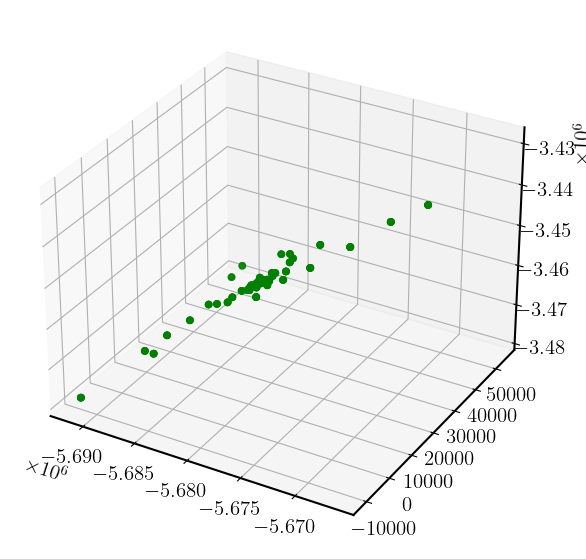

In [17]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(ska_antpos_ENU[:, 0], ska_antpos_ENU[:, 1], ska_antpos_ENU[:, 2], color = "green")

Text(0.5, 0.92, 'In geocentric frame')

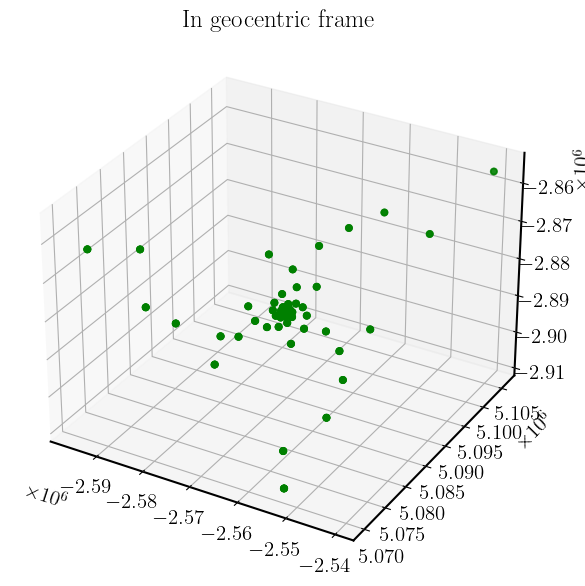

In [18]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(ska_antpos_ECEF[:, 0], ska_antpos_ECEF[:, 1], ska_antpos_ECEF[:, 2], color = "green")
ax.set_title('In geocentric frame')

Let's plot the SKA1-Low array layout, with an insert zooming on SKA core antennas.

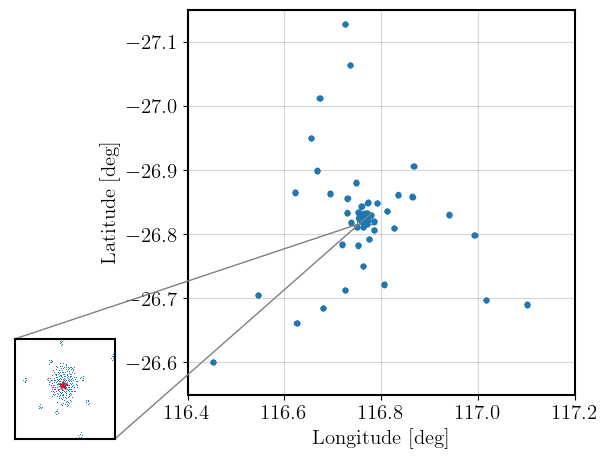

In [19]:
# from tools21cm, copyright Sambit Giri
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax = plt.subplots(figsize=(5, 5))
plt.plot(ska_antpos[:,0], ska_antpos[:,1], '.')
x1, x2, y1, y2 = 116.4, 117.2, -26.55, -27.15
ax.set_xlim(x1, x2)
ax.set_xlabel(r'Longitude [deg]')
ax.set_ylim(y1, y2)
ax.set_ylabel('Latitude [deg]')
ax.grid(visible=True, alpha=0.5)

axins = inset_axes(ax, 1, 1, loc=4, bbox_to_anchor=(0.2, 0.2))
plt.plot(ska_antpos[:,0], ska_antpos[:,1], ',')
plt.scatter(telescope_location[0], telescope_location[1], marker='*', color='r')
x1, x2, y1, y2 = 116.75, 116.78, -26.815, -26.833
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.grid(visible=True, alpha=0.5)
mark_inset(ax, axins, loc1=4, loc2=2, fc="none", ec="0.5")
axins.axes.xaxis.set_ticks([]);
axins.axes.yaxis.set_ticks([]);

**_NOTE:_**  These coordinates are the coordinates of the SKA *stations*, each made of 256 antennas. For now, we will make the assumption that each station is a single antenna, but this might need to be reconsidered in the future.

### Form baselines

In [20]:
blpairs = list(combinations(ska_ants, 2))
print(f'{len(blpairs)} baseline pairs.')

130816 baseline pairs.


In [21]:
blvecs = [ska_antpos_ECEF[ant1] - ska_antpos_ECEF[ant2] for (ant1, ant2) in blpairs]
lens = [np.linalg.norm(blvec) for blvec in blvecs]
print(f'Shortest baseline: {np.min(lens):.1f}m, longest baseline: {np.max(lens):.1e}m')

Shortest baseline: 35.1m, longest baseline: 6.5e+04m


Text(0.5, 1.0, 'Distribution of baseline lengths for SKA1-Low')

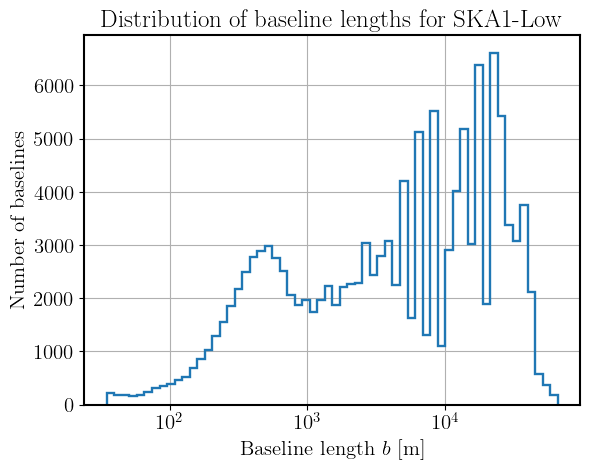

In [22]:
plt.figure()
plt.grid()
_ = plt.hist(np.log10(lens), bins=60, histtype='step', lw=1.7)
plt.xlabel(r'Baseline length $b$ [m]')
plt.ylabel('Number of baselines')
plt.xticks([2, 3, 4], labels=[r'$10^2$', r'$10^3$', r'$10^4$'])
plt.title('Distribution of baseline lengths for SKA1-Low')